In [345]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import utils
from Sampling import Sampling
from VAE import VAE
from CAN import CAN

In [346]:
vae_epoch = 10000
can_epoch = 10000
batch_size = 64
latent_dim = 10
beta_eeg = 5.0

In [348]:
data_root = "/home/zainkhan/bci-representation-learning"
eeg_train, eeg_test, pupil_train, pupil_test, sub_cond = utils.read_single_trial_datasets(data_root)
sub_cond_train = sub_cond[:eeg_train.shape[0], :]
sub_cond_test = sub_cond[eeg_train.shape[0]:, :]
eeg_train, eeg_test = utils.remove_noisy_trials(eeg_train, eeg_test)

for i in range(eeg_train.shape[0]):
    eeg_train[i,:,:,:] = gaussian_filter(eeg_train[i], sigma=2)
for i in range(eeg_test.shape[0]):
    eeg_test[i,:,:,:] = gaussian_filter(eeg_test[i], sigma=2)

sub_cond_train, sub_cond_test = utils.remove_noisy_trials(sub_cond_train, sub_cond_test)
eeg = np.concatenate((eeg_train, eeg_test), axis=0)
sub_cond = np.concatenate((sub_cond_train, sub_cond_test), axis=0)

In [349]:
# Load all encoders/decoders
vae = VAE(beta=beta_eeg, latent_dim=latent_dim)
vae.encoder = keras.models.load_model("vae_encoder_smooth/vae_encoder")
vae.decoder = keras.models.load_model("vae_decoder_smooth/vae_decoder")

In [350]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)    
plt.rc('ytick', labelsize=MEDIUM_SIZE)    
plt.rc('legend', fontsize=MEDIUM_SIZE)    
plt.rc('figure', titlesize=BIGGER_SIZE)

plt.style.use('seaborn-whitegrid')
plt.rcParams['figure.figsize'] = [8, 8]

In [351]:
def image_split(orig, rec):
    orig, rec = np.squeeze(orig), np.squeeze(rec)
    orig = np.mean(orig, axis=0)
    rec = np.mean(rec, axis=0)
    
    orig_targ = orig[:len(orig)//2]
    rec_targ = rec[:len(rec)//2]
    orig_dist = orig[len(orig)//2:]
    rec_dist = rec[len(rec)//2:]
    
    return (orig_targ, orig_dist, rec_targ, rec_dist)

In [352]:
def plot_eeg_reconstruction(orig, rec, save=False, filename=''):
    plt.rcParams['figure.figsize'] = [12, 10]
    orig_targ, orig_dist, rec_targ, rec_dist = image_split(orig, rec)
    
    mse = lambda x,y : np.mean(np.square(x - y))
    err_t = np.sqrt(mse(orig_targ, rec_targ))
    err_d = np.sqrt(mse(orig_dist, rec_dist))
    corr_t = pearsonr(orig_targ, rec_targ)[0]
    corr_d = pearsonr(orig_dist, rec_dist)[0]
    
    x = np.linspace(-500, 1000, num=orig.shape[1]//2)
    plt.subplot(2, 1, 1)
    plt.plot(x, orig_targ, label='Original')
    plt.plot(x, rec_targ, label='Reconstruction')
    plt.plot([], [], ' ', label=f'RMSE: {err_t:.2f}')
    plt.plot([], [], ' ', label=f'Corr.: {corr_t:.2f}')
    plt.legend(loc='upper left', frameon=True)
    plt.title('Channel Averaged Original vs Reconstruction', fontsize=16)
    plt.ylabel('Targets (Avg Z)')

    plt.subplot(2, 1, 2)
    plt.plot(x, orig_dist, label='Original')
    plt.plot(x, rec_dist, label='Reconstruction')  
    plt.plot([], [], ' ', label=f'RMSE: {err_d:.2f}')
    plt.plot([], [], ' ', label=f'Corr.: {corr_d:.2f}')
    plt.xlabel('Time (ms)')
    plt.ylabel('Distractors (Avg Z)')
    plt.legend(loc='upper left', frameon=True)
    fig = plt.gcf()
    plt.show()

    if save:
        fig.savefig(filename + '.png')

In [353]:
_, _, eeg_encode = vae.encoder.predict(eeg)
ee_rec = vae.decoder.predict(eeg_encode)

eeg_encode_train = eeg_encode[:len(eeg_train)]
eeg_encode_test = eeg_encode[len(eeg_train):]

ee_rec_train = ee_rec[:len(eeg_train)]
ee_rec_test = ee_rec[len(eeg_train):]

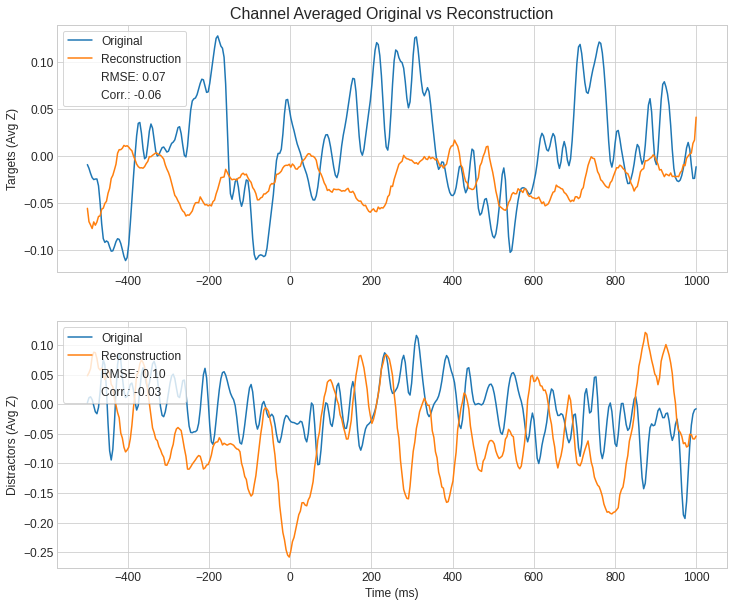

In [354]:
i = 250
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_test[i], ee_rec_test[i], save=False, filename=fn)

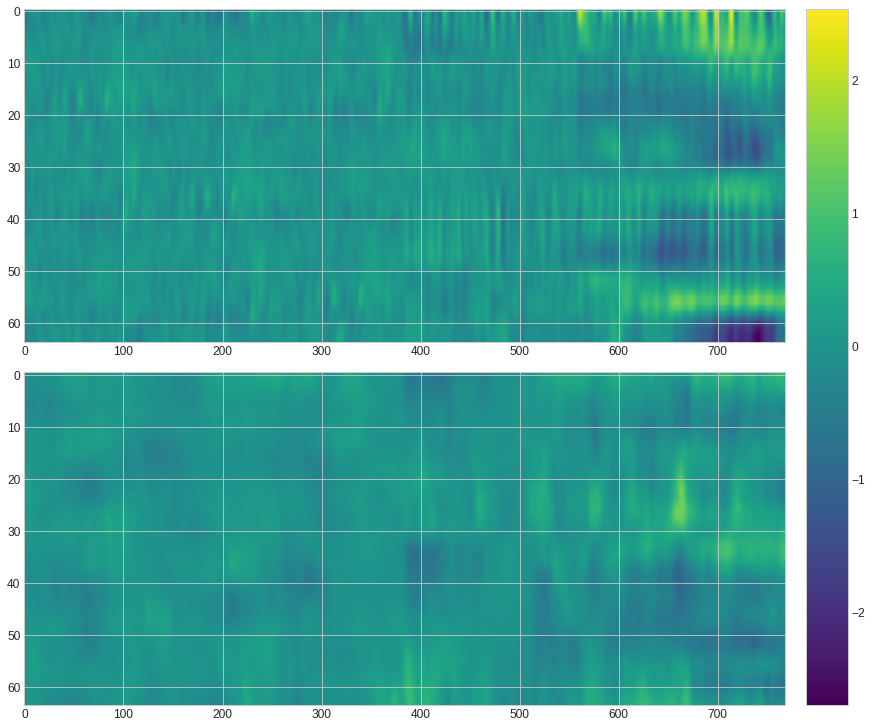

In [355]:
def plot_image(img, rec):
    plt.rcParams['figure.figsize'] = [12, 10]
    
    fig, axes = plt.subplots(nrows=2, ncols=1, constrained_layout=True)
    
    im = axes[0].imshow(img, aspect='auto', cmap='viridis')
    clim = im.properties()['clim']
    axes[1].imshow(rec, clim=clim, aspect='auto', cmap='viridis')
    fig.colorbar(im, ax=axes.ravel().tolist())


i = 100
plot_image(eeg_test[i], ee_rec[i])

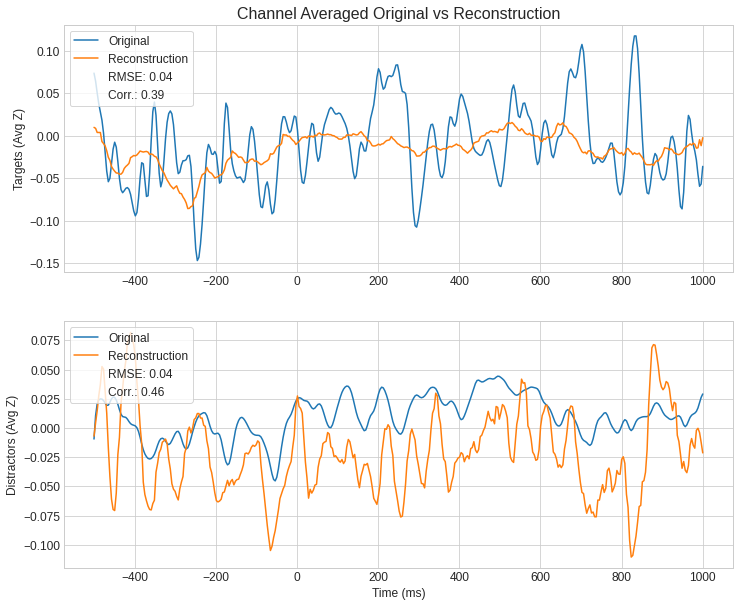

In [356]:
i = 2000
fn = 'ee' + str(i)
plot_eeg_reconstruction(eeg_train[i], ee_rec_train[i], save=False, filename=fn)

In [357]:
def plot_subj_cond(X, vals, ylabel, legend, filename='', width=0.8):
    plt.rcParams['figure.figsize'] = [15, 8]
    n = len(vals)
    _X = np.arange(len(X))
    for i in range(n):
        plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                width=width/float(n), align='edge', label=legend[i])   
    plt.xticks(_X, X)
    plt.xlabel('Subject (#)')
    plt.ylabel(ylabel)
    plt.legend(loc='upper left', frameon=True)
    fig = plt.gcf()
    plt.show()

    if filename != '':
        fig.savefig(filename + '.png')

In [358]:
eeg_free = []
eeg_eye = []
for i in range(8,17):
    free = np.where(np.logical_and(sub_cond[:,0]==str(i), sub_cond[:,1]=='free'))
    eye = np.where(np.logical_and(sub_cond[:,0]==str(i), sub_cond[:,1]=='eye'))
    
    eeg_free.append(eeg[free,:,:,:][0])
    eeg_eye.append(eeg[eye,:,:,:][0])

In [359]:
eeg_free[0].shape

(91, 64, 768, 1)

In [360]:
eeg_free_rec = []
eeg_eye_rec = []
for i in range(len(eeg_free)):
    _, _, encoded = vae.encoder.predict(eeg_free[i])
    eeg_free_rec.append(vae.decoder.predict(encoded))
    
    _, _, encoded = vae.encoder.predict(eeg_eye[i])
    eeg_eye_rec.append(vae.decoder.predict(encoded))

In [361]:
simplify = lambda a: np.squeeze(np.mean(a, axis=(0,1)))
for i in range(len(eeg_free)):
    eeg_free[i] = simplify(eeg_free[i])
    eeg_eye[i] = simplify(eeg_eye[i])
    eeg_free_rec[i] = simplify(eeg_free_rec[i])
    eeg_eye_rec[i] = simplify(eeg_eye_rec[i])

In [362]:
eeg_free[-1].shape

(768,)

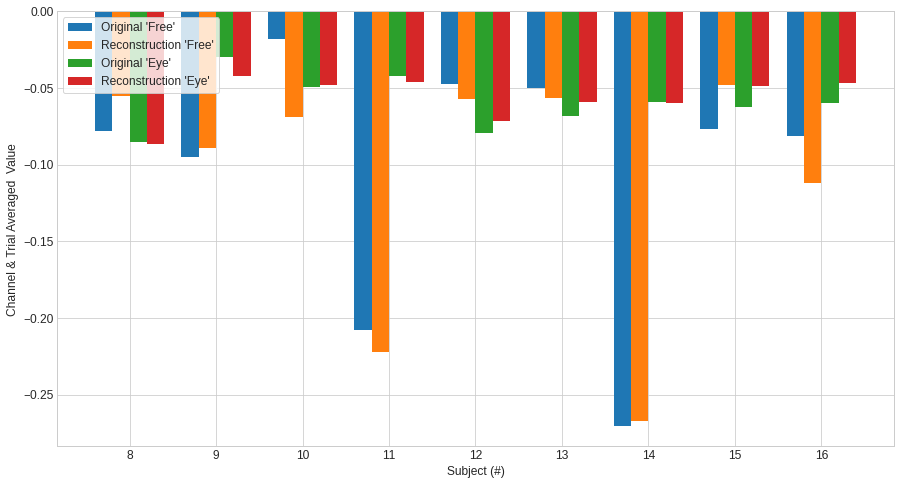

In [366]:
filename = ''
f = lambda x: np.min(x)
ef = [f(i) for i in eeg_free]
efr = [f(i) for i in eeg_free_rec]
ee = [f(i) for i in eeg_eye]
eer = [f(i) for i in eeg_eye_rec]

legend = ['Original \'Free\'', 'Reconstruction \'Free\'', 'Original \'Eye\'', 'Reconstruction \'Eye\'']
ylabel = f'Channel & Trial Averaged {filename} Value'
plot_subj_cond(range(8,17), [ef, efr, ee, eer], ylabel, legend, filename)

In [367]:
eeg_free_targ = [i[:len(i)//2] for i in eeg_free]
eeg_free_dist = [i[len(i)//2:] for i in eeg_free]
eeg_eye_targ = [i[:len(i)//2] for i in eeg_eye]
eeg_eye_dist = [i[len(i)//2:] for i in eeg_eye]

eeg_free_rec_targ = [i[:len(i)//2] for i in eeg_free_rec]
eeg_free_rec_dist = [i[len(i)//2:] for i in eeg_free_rec]
eeg_eye_rec_targ = [i[:len(i)//2] for i in eeg_eye_rec]
eeg_eye_rec_dist = [i[len(i)//2:] for i in eeg_eye_rec]

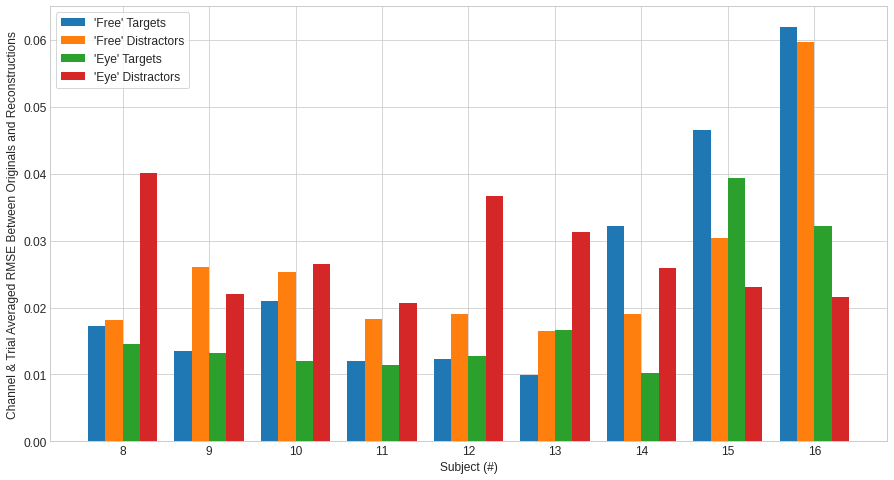

In [369]:
filename = 'RMSE'
#g = lambda x, y: pearsonr(x, y)[0]
g = lambda x, y: np.sqrt(np.mean((x-y)**2))
eft = [g(eeg_free_targ[i], eeg_free_rec_targ[i]) for i in range(len(eeg_free_targ))]
efd = [g(eeg_free_dist[i], eeg_free_rec_dist[i]) for i in range(len(eeg_free_dist))]
eet = [g(eeg_eye_targ[i], eeg_eye_rec_targ[i]) for i in range(len(eeg_eye_targ))]
eed = [g(eeg_eye_dist[i], eeg_eye_rec_targ[i]) for i in range(len(eeg_eye_dist))]

legend = ['\'Free\' Targets', '\'Free\' Distractors', '\'Eye\' Targets', '\'Eye\' Distractors']
ylabel = f'Channel & Trial Averaged {filename} Between Originals and Reconstructions'
plot_subj_cond(range(8,17), [eft, efd, eet, eed], ylabel, legend, filename)

In [370]:
from sklearn import manifold

def plot_embedding(X, colormetric, title=None, filename=None, labels=None):
    plt.rcParams['figure.figsize'] = [12, 10]
    plt.figure()
    ax = plt.subplot(111)
    #for i in range(X.shape[0]):
        #plt.text(X[i, 0], X[i, 1], str(y[i]), color=plt.cm.Set1(colormetric[i]))
    im = ax.scatter(X[:, 0], X[:, 1], c=colormetric, cmap='viridis')
    ax.set_xlabel('X0')
    ax.set_ylabel('X1')
    if title is not None:
        plt.title(title)
    cb = plt.colorbar(im)
    cb.set_label(filename)
    fig = plt.gcf()
    plt.show()
    if filename != '':
        fig.savefig(filename + 'tSNE.png')

In [371]:
tsne = manifold.TSNE(n_components=2, perplexity=50, init='pca', random_state=0)
X_tsne = tsne.fit_transform(eeg_encode)

In [372]:
print(eeg.shape)
print(sub_cond.shape)

(2614, 64, 768, 1)
(2614, 2)


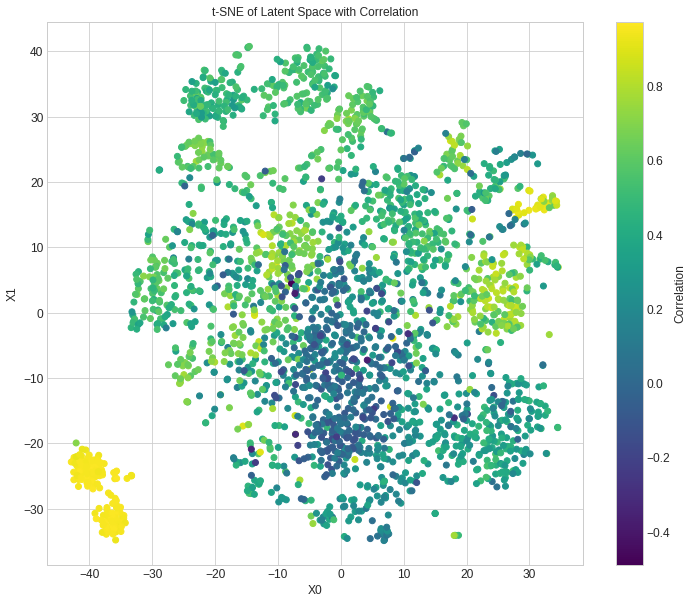

In [374]:
filename = 'Correlation'
simplify = lambda x: np.squeeze(np.mean(x, axis=0))
g = lambda x, y: pearsonr(x, y)[0]

eeg_red = []
ee_rec_red = []
for i in range(len(eeg)):
    eeg_red.append(simplify(eeg[i]))
    ee_rec_red.append(simplify(ee_rec[i]))

y = range(len(X_tsne))
corr = [g(eeg_red[i], ee_rec_red[i]) for i in y]
sub = [int(i[0]) for i in sub_cond]
plot_embedding(X_tsne, corr, f't-SNE of Latent Space with {filename}', filename)

In [249]:
len(X_tsne)

2614